In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_ce_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "CIFAR10"
ood = "0:1:2:3:4"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

Files already downloaded and verified


  0%|                                                                                                                                                          | 0/50000 [00:00<?, ?it/s]

  8%|███████████▊                                                                                                                                | 4231/50000 [00:00<00:01, 42299.96it/s]

 17%|████████████████████████▏                                                                                                                   | 8658/50000 [00:00<00:00, 43453.29it/s]

 26%|████████████████████████████████████▎                                                                                                      | 13065/50000 [00:00<00:00, 43733.59it/s]

 35%|████████████████████████████████████████████████▋                                                                                          | 17494/50000 [00:00<00:00, 43951.47it/s]

 44%|████████████████████████████████████████████████████████████▉                                                                              | 21938/50000 [00:00<00:00, 44126.92it/s]

 53%|█████████████████████████████████████████████████████████████████████████▎                                                                 | 26351/50000 [00:00<00:00, 44053.89it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████▌                                                     | 30780/50000 [00:00<00:00, 44128.80it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 35193/50000 [00:00<00:00, 43989.28it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 39593/50000 [00:00<00:00, 42559.23it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 43933/50000 [00:01<00:00, 42811.58it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 48317/50000 [00:01<00:00, 43118.66it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 43441.84it/s]

Files already downloaded and verified


  0%|                                                                                                                                                          | 0/10000 [00:00<?, ?it/s]

 44%|█████████████████████████████████████████████████████████████▍                                                                              | 4389/10000 [00:00<00:00, 43885.02it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 8778/10000 [00:00<00:00, 42465.31it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 42220.39it/s]

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:1:2:3:4 5izbkda2


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-5izbkda2:best, 58.53MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.3


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []
    trn_rcn_fpi = []
    trn_emb_fpi = []
    trn_lgt_fpi = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []
    val_rcn_fpi = []
    val_emb_fpi = []
    val_lgt_fpi = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []
    ind_rcn_fpi = []
    ind_emb_fpi = []
    ind_lgt_fpi = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []
        ood_rcn_fpi = []
        ood_emb_fpi = []
        ood_lgt_fpi = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []
    rnd_rcn_fpi = []
    rnd_emb_fpi = []
    rnd_lgt_fpi = []

    fpi = 10

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_rcn_fpi.extend(rcn.detach().cpu().numpy())
        trn_emb_fpi.extend(emb.detach().cpu().numpy())
        trn_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_rcn_fpi.extend(rcn.detach().cpu().numpy())
        val_emb_fpi.extend(emb.detach().cpu().numpy())
        val_lgt_fpi.extend(lgt.detach().cpu().numpy())
        
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_rcn_fpi.extend(rcn.detach().cpu().numpy())
        ind_emb_fpi.extend(emb.detach().cpu().numpy())
        ind_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_rcn_fpi.extend(rcn.detach().cpu().numpy())
            ood_emb_fpi.extend(emb.detach().cpu().numpy())
            ood_lgt_fpi.extend(lgt.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
        for i in range(fpi):
            emb, lgt, rcn = model(rcn)
        rnd_rcn_fpi.extend(rcn.detach().cpu().numpy())
        rnd_emb_fpi.extend(emb.detach().cpu().numpy())
        rnd_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                            | 0/157 [00:00<?, ?it/s]

  1%|▉                                                                                                                                                   | 1/157 [00:01<02:52,  1.10s/it]

  2%|██▊                                                                                                                                                 | 3/157 [00:01<00:51,  2.99it/s]

  3%|████▋                                                                                                                                               | 5/157 [00:01<00:29,  5.11it/s]

  4%|██████▌                                                                                                                                             | 7/157 [00:01<00:21,  7.13it/s]

  6%|████████▍                                                                                                                                           | 9/157 [00:01<00:16,  8.93it/s]

  7%|██████████▎                                                                                                                                        | 11/157 [00:01<00:13, 10.46it/s]

  8%|████████████▏                                                                                                                                      | 13/157 [00:01<00:12, 11.71it/s]

 10%|██████████████                                                                                                                                     | 15/157 [00:02<00:11, 12.68it/s]

 11%|███████████████▉                                                                                                                                   | 17/157 [00:02<00:10, 13.42it/s]

 12%|█████████████████▊                                                                                                                                 | 19/157 [00:02<00:09, 13.96it/s]

 13%|███████████████████▋                                                                                                                               | 21/157 [00:02<00:09, 14.36it/s]

 15%|█████████████████████▌                                                                                                                             | 23/157 [00:02<00:09, 14.65it/s]

 16%|███████████████████████▍                                                                                                                           | 25/157 [00:02<00:08, 14.86it/s]

 17%|█████████████████████████▎                                                                                                                         | 27/157 [00:02<00:08, 15.00it/s]

 18%|███████████████████████████▏                                                                                                                       | 29/157 [00:02<00:08, 15.10it/s]

 20%|█████████████████████████████                                                                                                                      | 31/157 [00:03<00:08, 15.18it/s]

 21%|██████████████████████████████▉                                                                                                                    | 33/157 [00:03<00:08, 15.23it/s]

 22%|████████████████████████████████▊                                                                                                                  | 35/157 [00:03<00:07, 15.26it/s]

 24%|██████████████████████████████████▋                                                                                                                | 37/157 [00:03<00:07, 15.29it/s]

 25%|████████████████████████████████████▌                                                                                                              | 39/157 [00:03<00:07, 15.31it/s]

 26%|██████████████████████████████████████▍                                                                                                            | 41/157 [00:03<00:07, 15.32it/s]

 27%|████████████████████████████████████████▎                                                                                                          | 43/157 [00:03<00:07, 15.32it/s]

 29%|██████████████████████████████████████████▏                                                                                                        | 45/157 [00:03<00:07, 15.33it/s]

 30%|████████████████████████████████████████████                                                                                                       | 47/157 [00:04<00:07, 15.33it/s]

 31%|█████████████████████████████████████████████▉                                                                                                     | 49/157 [00:04<00:07, 15.33it/s]

 32%|███████████████████████████████████████████████▊                                                                                                   | 51/157 [00:04<00:06, 15.34it/s]

 34%|█████████████████████████████████████████████████▌                                                                                                 | 53/157 [00:04<00:06, 15.34it/s]

 35%|███████████████████████████████████████████████████▍                                                                                               | 55/157 [00:04<00:06, 15.34it/s]

 36%|█████████████████████████████████████████████████████▎                                                                                             | 57/157 [00:04<00:06, 15.34it/s]

 38%|███████████████████████████████████████████████████████▏                                                                                           | 59/157 [00:04<00:06, 15.34it/s]

 39%|█████████████████████████████████████████████████████████                                                                                          | 61/157 [00:05<00:06, 15.35it/s]

 40%|██████████████████████████████████████████████████████████▉                                                                                        | 63/157 [00:05<00:06, 15.35it/s]

 41%|████████████████████████████████████████████████████████████▊                                                                                      | 65/157 [00:05<00:05, 15.34it/s]

 43%|██████████████████████████████████████████████████████████████▋                                                                                    | 67/157 [00:05<00:05, 15.35it/s]

 44%|████████████████████████████████████████████████████████████████▌                                                                                  | 69/157 [00:05<00:05, 15.35it/s]

 45%|██████████████████████████████████████████████████████████████████▍                                                                                | 71/157 [00:05<00:05, 15.35it/s]

 46%|████████████████████████████████████████████████████████████████████▎                                                                              | 73/157 [00:05<00:05, 15.35it/s]

 48%|██████████████████████████████████████████████████████████████████████▏                                                                            | 75/157 [00:05<00:05, 15.35it/s]

 49%|████████████████████████████████████████████████████████████████████████                                                                           | 77/157 [00:06<00:05, 15.35it/s]

 50%|█████████████████████████████████████████████████████████████████████████▉                                                                         | 79/157 [00:06<00:05, 15.35it/s]

 52%|███████████████████████████████████████████████████████████████████████████▊                                                                       | 81/157 [00:06<00:04, 15.35it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▋                                                                     | 83/157 [00:06<00:04, 15.34it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▌                                                                   | 85/157 [00:06<00:04, 15.34it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▍                                                                 | 87/157 [00:06<00:04, 15.34it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▎                                                               | 89/157 [00:06<00:04, 15.35it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▏                                                             | 91/157 [00:06<00:04, 15.35it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████                                                            | 93/157 [00:07<00:04, 15.35it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 95/157 [00:07<00:04, 15.34it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 97/157 [00:07<00:03, 15.35it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 99/157 [00:07<00:03, 15.35it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 101/157 [00:07<00:03, 15.35it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 103/157 [00:07<00:03, 15.35it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 105/157 [00:07<00:03, 15.35it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 107/157 [00:08<00:03, 15.34it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 109/157 [00:08<00:03, 15.34it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 111/157 [00:08<00:02, 15.35it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 113/157 [00:08<00:02, 15.35it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 115/157 [00:08<00:02, 15.35it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 117/157 [00:08<00:02, 15.35it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 119/157 [00:08<00:02, 15.35it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 121/157 [00:08<00:02, 15.34it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 123/157 [00:09<00:02, 15.34it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 125/157 [00:09<00:02, 15.34it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 127/157 [00:09<00:01, 15.35it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 129/157 [00:09<00:01, 15.35it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 131/157 [00:09<00:01, 15.35it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 133/157 [00:09<00:01, 15.35it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 135/157 [00:09<00:01, 15.35it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 137/157 [00:09<00:01, 15.34it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 139/157 [00:10<00:01, 15.35it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 141/157 [00:10<00:01, 15.35it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 143/157 [00:10<00:00, 15.35it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 145/157 [00:10<00:00, 15.35it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 147/157 [00:10<00:00, 15.35it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 149/157 [00:10<00:00, 15.33it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 151/157 [00:10<00:00, 15.34it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 153/157 [00:11<00:00, 15.35it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 155/157 [00:11<00:00, 15.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:11<00:00, 15.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:11<00:00, 13.92it/s]

train - OK


  0%|                                                                                                                                                             | 0/40 [00:00<?, ?it/s]

  2%|███▋                                                                                                                                                 | 1/40 [00:00<00:05,  6.58it/s]

  8%|███████████▏                                                                                                                                         | 3/40 [00:00<00:03, 11.37it/s]

 12%|██████████████████▋                                                                                                                                  | 5/40 [00:00<00:02, 13.11it/s]

 18%|██████████████████████████                                                                                                                           | 7/40 [00:00<00:02, 13.95it/s]

 22%|█████████████████████████████████▌                                                                                                                   | 9/40 [00:00<00:02, 14.44it/s]

 28%|████████████████████████████████████████▋                                                                                                           | 11/40 [00:00<00:01, 14.74it/s]

 32%|████████████████████████████████████████████████                                                                                                    | 13/40 [00:00<00:01, 14.94it/s]

 38%|███████████████████████████████████████████████████████▌                                                                                            | 15/40 [00:01<00:01, 15.07it/s]

 42%|██████████████████████████████████████████████████████████████▉                                                                                     | 17/40 [00:01<00:01, 15.15it/s]

 48%|██████████████████████████████████████████████████████████████████████▎                                                                             | 19/40 [00:01<00:01, 15.20it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▋                                                                      | 21/40 [00:01<00:01, 15.24it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████                                                               | 23/40 [00:01<00:01, 15.27it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 25/40 [00:01<00:00, 15.29it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 27/40 [00:01<00:00, 15.31it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 29/40 [00:01<00:00, 15.32it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 31/40 [00:02<00:00, 15.33it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 33/40 [00:02<00:00, 15.33it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 35/40 [00:02<00:00, 15.34it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 37/40 [00:02<00:00, 15.29it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 39/40 [00:02<00:00, 15.30it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 14.68it/s]

val - OK


  0%|                                                                                                                                                             | 0/40 [00:00<?, ?it/s]

  2%|███▋                                                                                                                                                 | 1/40 [00:00<00:06,  6.10it/s]

  8%|███████████▏                                                                                                                                         | 3/40 [00:00<00:03, 10.98it/s]

 12%|██████████████████▋                                                                                                                                  | 5/40 [00:00<00:02, 12.86it/s]

 18%|██████████████████████████                                                                                                                           | 7/40 [00:00<00:02, 13.81it/s]

 22%|█████████████████████████████████▌                                                                                                                   | 9/40 [00:00<00:02, 14.35it/s]

 28%|████████████████████████████████████████▋                                                                                                           | 11/40 [00:00<00:01, 14.68it/s]

 32%|████████████████████████████████████████████████                                                                                                    | 13/40 [00:00<00:01, 14.90it/s]

 38%|███████████████████████████████████████████████████████▌                                                                                            | 15/40 [00:01<00:01, 15.04it/s]

 42%|██████████████████████████████████████████████████████████████▉                                                                                     | 17/40 [00:01<00:01, 15.14it/s]

 48%|██████████████████████████████████████████████████████████████████████▎                                                                             | 19/40 [00:01<00:01, 15.20it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▋                                                                      | 21/40 [00:01<00:01, 15.25it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████                                                               | 23/40 [00:01<00:01, 15.28it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 25/40 [00:01<00:00, 15.30it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 27/40 [00:01<00:00, 15.32it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 29/40 [00:01<00:00, 15.33it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 31/40 [00:02<00:00, 15.33it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 33/40 [00:02<00:00, 15.33it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 35/40 [00:02<00:00, 15.34it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 37/40 [00:02<00:00, 15.34it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 39/40 [00:02<00:00, 15.34it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 14.82it/s]

test InD - OK


  0%|                                                                                                                                                            | 0/235 [00:00<?, ?it/s]

  0%|▋                                                                                                                                                   | 1/235 [00:00<00:39,  5.95it/s]

  1%|█▉                                                                                                                                                  | 3/235 [00:00<00:21, 10.85it/s]

  2%|███▏                                                                                                                                                | 5/235 [00:00<00:18, 12.76it/s]

  3%|████▍                                                                                                                                               | 7/235 [00:00<00:16, 13.74it/s]

  4%|█████▋                                                                                                                                              | 9/235 [00:00<00:15, 14.30it/s]

  5%|██████▉                                                                                                                                            | 11/235 [00:00<00:15, 14.65it/s]

  6%|████████▏                                                                                                                                          | 13/235 [00:00<00:14, 14.87it/s]

  6%|█████████▍                                                                                                                                         | 15/235 [00:01<00:14, 15.01it/s]

  7%|██████████▋                                                                                                                                        | 17/235 [00:01<00:14, 15.11it/s]

  8%|███████████▉                                                                                                                                       | 19/235 [00:01<00:14, 15.18it/s]

  9%|█████████████▏                                                                                                                                     | 21/235 [00:01<00:14, 15.23it/s]

 10%|██████████████▍                                                                                                                                    | 23/235 [00:01<00:13, 15.26it/s]

 11%|███████████████▋                                                                                                                                   | 25/235 [00:01<00:13, 15.29it/s]

 11%|████████████████▉                                                                                                                                  | 27/235 [00:01<00:13, 15.30it/s]

 12%|██████████████████▏                                                                                                                                | 29/235 [00:01<00:13, 15.31it/s]

 13%|███████████████████▍                                                                                                                               | 31/235 [00:02<00:13, 15.32it/s]

 14%|████████████████████▋                                                                                                                              | 33/235 [00:02<00:13, 15.33it/s]

 15%|█████████████████████▉                                                                                                                             | 35/235 [00:02<00:13, 15.33it/s]

 16%|███████████████████████▏                                                                                                                           | 37/235 [00:02<00:12, 15.33it/s]

 17%|████████████████████████▍                                                                                                                          | 39/235 [00:02<00:12, 15.33it/s]

 17%|█████████████████████████▋                                                                                                                         | 41/235 [00:02<00:12, 15.33it/s]

 18%|██████████████████████████▉                                                                                                                        | 43/235 [00:02<00:12, 15.33it/s]

 19%|████████████████████████████▏                                                                                                                      | 45/235 [00:03<00:12, 15.33it/s]

 20%|█████████████████████████████▍                                                                                                                     | 47/235 [00:03<00:12, 15.33it/s]

 21%|██████████████████████████████▋                                                                                                                    | 49/235 [00:03<00:12, 15.33it/s]

 22%|███████████████████████████████▉                                                                                                                   | 51/235 [00:03<00:12, 15.33it/s]

 23%|█████████████████████████████████▏                                                                                                                 | 53/235 [00:03<00:11, 15.33it/s]

 23%|██████████████████████████████████▍                                                                                                                | 55/235 [00:03<00:11, 15.34it/s]

 24%|███████████████████████████████████▋                                                                                                               | 57/235 [00:03<00:11, 15.33it/s]

 25%|████████████████████████████████████▉                                                                                                              | 59/235 [00:03<00:11, 15.33it/s]

 26%|██████████████████████████████████████▏                                                                                                            | 61/235 [00:04<00:11, 15.34it/s]

 27%|███████████████████████████████████████▍                                                                                                           | 63/235 [00:04<00:11, 15.34it/s]

 28%|████████████████████████████████████████▋                                                                                                          | 65/235 [00:04<00:11, 15.33it/s]

 29%|█████████████████████████████████████████▉                                                                                                         | 67/235 [00:04<00:10, 15.33it/s]

 29%|███████████████████████████████████████████▏                                                                                                       | 69/235 [00:04<00:10, 15.34it/s]

 30%|████████████████████████████████████████████▍                                                                                                      | 71/235 [00:04<00:10, 15.34it/s]

 31%|█████████████████████████████████████████████▋                                                                                                     | 73/235 [00:04<00:10, 15.33it/s]

 32%|██████████████████████████████████████████████▉                                                                                                    | 75/235 [00:04<00:10, 15.33it/s]

 33%|████████████████████████████████████████████████▏                                                                                                  | 77/235 [00:05<00:10, 15.34it/s]

 34%|█████████████████████████████████████████████████▍                                                                                                 | 79/235 [00:05<00:10, 15.34it/s]

 34%|██████████████████████████████████████████████████▋                                                                                                | 81/235 [00:05<00:10, 15.34it/s]

 35%|███████████████████████████████████████████████████▉                                                                                               | 83/235 [00:05<00:09, 15.33it/s]

 36%|█████████████████████████████████████████████████████▏                                                                                             | 85/235 [00:05<00:09, 15.33it/s]

 37%|██████████████████████████████████████████████████████▍                                                                                            | 87/235 [00:05<00:09, 15.33it/s]

 38%|███████████████████████████████████████████████████████▋                                                                                           | 89/235 [00:05<00:09, 15.34it/s]

 39%|████████████████████████████████████████████████████████▉                                                                                          | 91/235 [00:06<00:09, 15.34it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                        | 93/235 [00:06<00:09, 15.34it/s]

 40%|███████████████████████████████████████████████████████████▍                                                                                       | 95/235 [00:06<00:09, 15.33it/s]

 41%|████████████████████████████████████████████████████████████▋                                                                                      | 97/235 [00:06<00:09, 15.33it/s]

 42%|█████████████████████████████████████████████████████████████▉                                                                                     | 99/235 [00:06<00:08, 15.34it/s]

 43%|██████████████████████████████████████████████████████████████▋                                                                                   | 101/235 [00:06<00:08, 15.34it/s]

 44%|███████████████████████████████████████████████████████████████▉                                                                                  | 103/235 [00:06<00:08, 15.33it/s]

 45%|█████████████████████████████████████████████████████████████████▏                                                                                | 105/235 [00:06<00:08, 15.34it/s]

 46%|██████████████████████████████████████████████████████████████████▍                                                                               | 107/235 [00:07<00:08, 15.32it/s]

 46%|███████████████████████████████████████████████████████████████████▋                                                                              | 109/235 [00:07<00:08, 15.33it/s]

 47%|████████████████████████████████████████████████████████████████████▉                                                                             | 111/235 [00:07<00:08, 15.33it/s]

 48%|██████████████████████████████████████████████████████████████████████▏                                                                           | 113/235 [00:07<00:07, 15.33it/s]

 49%|███████████████████████████████████████████████████████████████████████▍                                                                          | 115/235 [00:07<00:07, 15.33it/s]

 50%|████████████████████████████████████████████████████████████████████████▋                                                                         | 117/235 [00:07<00:07, 15.33it/s]

 51%|█████████████████████████████████████████████████████████████████████████▉                                                                        | 119/235 [00:07<00:07, 15.33it/s]

 51%|███████████████████████████████████████████████████████████████████████████▏                                                                      | 121/235 [00:07<00:07, 15.32it/s]

 52%|████████████████████████████████████████████████████████████████████████████▍                                                                     | 123/235 [00:08<00:07, 15.33it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▋                                                                    | 125/235 [00:08<00:07, 15.33it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▉                                                                   | 127/235 [00:08<00:07, 15.34it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▏                                                                 | 129/235 [00:08<00:06, 15.34it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▍                                                                | 131/235 [00:08<00:06, 15.34it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▋                                                               | 133/235 [00:08<00:06, 15.34it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▊                                                              | 135/235 [00:08<00:06, 15.34it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████                                                             | 137/235 [00:09<00:06, 15.33it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▎                                                           | 139/235 [00:09<00:06, 15.33it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                          | 141/235 [00:09<00:06, 15.33it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 143/235 [00:09<00:06, 15.33it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████                                                        | 145/235 [00:09<00:05, 15.34it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 147/235 [00:09<00:05, 15.34it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 149/235 [00:09<00:05, 15.33it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 151/235 [00:09<00:05, 15.34it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████                                                   | 153/235 [00:10<00:05, 15.33it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 155/235 [00:10<00:05, 15.32it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 157/235 [00:10<00:05, 15.33it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 159/235 [00:10<00:04, 15.33it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 161/235 [00:10<00:04, 15.33it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 163/235 [00:10<00:04, 15.33it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 165/235 [00:10<00:04, 15.34it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 167/235 [00:10<00:04, 15.34it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 169/235 [00:11<00:04, 15.34it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 171/235 [00:11<00:04, 15.34it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 173/235 [00:11<00:04, 15.34it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 175/235 [00:11<00:03, 15.33it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 177/235 [00:11<00:03, 15.33it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 179/235 [00:11<00:03, 15.34it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 181/235 [00:11<00:03, 15.34it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 183/235 [00:12<00:03, 15.34it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 185/235 [00:12<00:03, 15.34it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 187/235 [00:12<00:03, 15.34it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 189/235 [00:12<00:02, 15.34it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 191/235 [00:12<00:02, 15.34it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 193/235 [00:12<00:02, 15.34it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 195/235 [00:12<00:02, 15.34it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 197/235 [00:12<00:02, 15.32it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 199/235 [00:13<00:02, 15.32it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 201/235 [00:13<00:02, 15.33it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 203/235 [00:13<00:02, 15.33it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 205/235 [00:13<00:01, 15.33it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 207/235 [00:13<00:01, 15.33it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 209/235 [00:13<00:01, 15.33it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 211/235 [00:13<00:01, 15.34it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 213/235 [00:13<00:01, 15.34it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 215/235 [00:14<00:01, 15.34it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 217/235 [00:14<00:01, 15.34it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 219/235 [00:14<00:01, 15.34it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 221/235 [00:14<00:00, 15.32it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 223/235 [00:14<00:00, 15.33it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 225/235 [00:14<00:00, 15.33it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 227/235 [00:14<00:00, 15.33it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 229/235 [00:15<00:00, 15.33it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 231/235 [00:15<00:00, 15.33it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 233/235 [00:15<00:00, 15.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:15<00:00, 15.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:15<00:00, 15.20it/s]

test OoD - OK


  0%|                                                                                                                                                            | 0/100 [00:00<?, ?it/s]

  2%|██▉                                                                                                                                                 | 2/100 [00:00<00:06, 15.32it/s]

  4%|█████▉                                                                                                                                              | 4/100 [00:00<00:06, 15.32it/s]

  6%|████████▉                                                                                                                                           | 6/100 [00:00<00:06, 15.32it/s]

  8%|███████████▊                                                                                                                                        | 8/100 [00:00<00:06, 15.32it/s]

 10%|██████████████▋                                                                                                                                    | 10/100 [00:00<00:05, 15.32it/s]

 12%|█████████████████▋                                                                                                                                 | 12/100 [00:00<00:05, 15.32it/s]

 14%|████████████████████▌                                                                                                                              | 14/100 [00:00<00:05, 15.33it/s]

 16%|███████████████████████▌                                                                                                                           | 16/100 [00:01<00:05, 15.33it/s]

 18%|██████████████████████████▍                                                                                                                        | 18/100 [00:01<00:05, 15.33it/s]

 20%|█████████████████████████████▍                                                                                                                     | 20/100 [00:01<00:05, 15.33it/s]

 22%|████████████████████████████████▎                                                                                                                  | 22/100 [00:01<00:05, 15.33it/s]

 24%|███████████████████████████████████▎                                                                                                               | 24/100 [00:01<00:04, 15.34it/s]

 26%|██████████████████████████████████████▏                                                                                                            | 26/100 [00:01<00:04, 15.33it/s]

 28%|█████████████████████████████████████████▏                                                                                                         | 28/100 [00:01<00:04, 15.33it/s]

 30%|████████████████████████████████████████████                                                                                                       | 30/100 [00:01<00:04, 15.33it/s]

 32%|███████████████████████████████████████████████                                                                                                    | 32/100 [00:02<00:04, 15.33it/s]

 34%|█████████████████████████████████████████████████▉                                                                                                 | 34/100 [00:02<00:04, 15.33it/s]

 36%|████████████████████████████████████████████████████▉                                                                                              | 36/100 [00:02<00:04, 15.33it/s]

 38%|███████████████████████████████████████████████████████▊                                                                                           | 38/100 [00:02<00:04, 15.33it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                        | 40/100 [00:02<00:03, 15.33it/s]

 42%|█████████████████████████████████████████████████████████████▋                                                                                     | 42/100 [00:02<00:03, 15.33it/s]

 44%|████████████████████████████████████████████████████████████████▋                                                                                  | 44/100 [00:02<00:03, 15.33it/s]

 46%|███████████████████████████████████████████████████████████████████▌                                                                               | 46/100 [00:03<00:03, 15.33it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                            | 48/100 [00:03<00:03, 15.33it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 50/100 [00:03<00:03, 15.33it/s]

 52%|████████████████████████████████████████████████████████████████████████████▍                                                                      | 52/100 [00:03<00:03, 15.33it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▍                                                                   | 54/100 [00:03<00:03, 15.33it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                                | 56/100 [00:03<00:02, 15.32it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▎                                                             | 58/100 [00:03<00:02, 15.33it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 60/100 [00:03<00:02, 15.33it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 62/100 [00:04<00:02, 15.34it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████                                                     | 64/100 [00:04<00:02, 15.33it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 66/100 [00:04<00:02, 15.33it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 68/100 [00:04<00:02, 15.33it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 70/100 [00:04<00:01, 15.34it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 72/100 [00:04<00:01, 15.33it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 74/100 [00:04<00:01, 15.33it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 76/100 [00:04<00:01, 15.33it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 78/100 [00:05<00:01, 15.33it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 80/100 [00:05<00:01, 15.33it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 82/100 [00:05<00:01, 15.33it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 84/100 [00:05<00:01, 15.33it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 86/100 [00:05<00:00, 15.33it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 88/100 [00:05<00:00, 15.33it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 90/100 [00:05<00:00, 15.33it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 92/100 [00:06<00:00, 15.33it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 94/100 [00:06<00:00, 15.32it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 96/100 [00:06<00:00, 15.33it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 98/100 [00:06<00:00, 15.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.33it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)
trn_rcn_fpi = np.array(trn_rcn_fpi)
trn_emb_fpi = np.array(trn_emb_fpi).squeeze()
trn_lgt_fpi = np.array(trn_lgt_fpi).squeeze()

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)
val_rcn_fpi = np.array(val_rcn_fpi)
val_emb_fpi = np.array(val_emb_fpi).squeeze()
val_lgt_fpi = np.array(val_lgt_fpi).squeeze()

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)
ind_rcn_fpi = np.array(ind_rcn_fpi)
ind_emb_fpi = np.array(ind_emb_fpi).squeeze()
ind_lgt_fpi = np.array(ind_lgt_fpi).squeeze()

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)
    ood_rcn_fpi = np.array(ood_rcn_fpi)
    ood_emb_fpi = np.array(ood_emb_fpi).squeeze()
    ood_lgt_fpi = np.array(ood_lgt_fpi).squeeze()

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()
rnd_rcn_fpi = np.array(rnd_rcn_fpi)
rnd_emb_fpi = np.array(rnd_emb_fpi).squeeze()
rnd_lgt_fpi = np.array(rnd_lgt_fpi).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(20000, 3, 32, 32) (20000, 3, 32, 32) (20000, 512) (20000, 5) (20000,)
(5000, 3, 32, 32) (5000, 3, 32, 32) (5000, 512) (5000, 5) (5000,)
(5000, 3, 32, 32) (5000, 3, 32, 32) (5000, 512) (5000, 5) (5000,)
(30000, 3, 32, 32) (30000, 3, 32, 32) (30000, 512) (30000, 5) (30000,)
(12800, 3, 32, 32) (12800, 3, 32, 32) (12800, 512) (12800, 5)


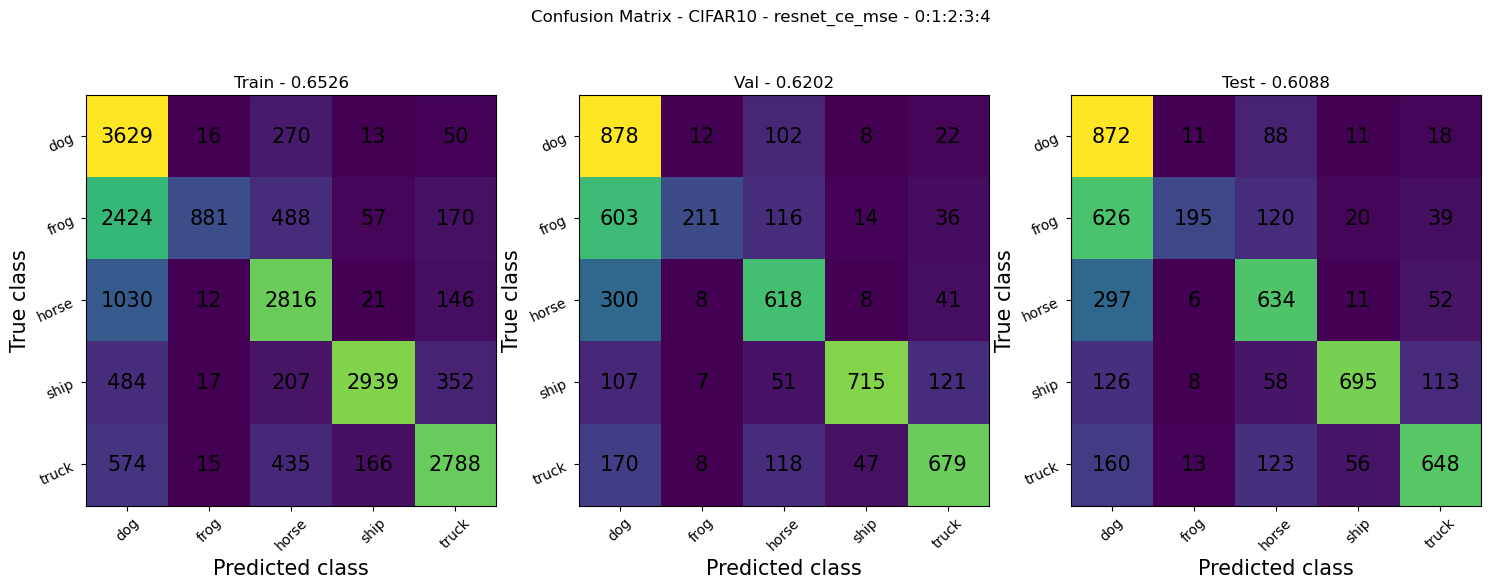

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt_fpi.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt_fpi.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt_fpi.argmax(-1)), torch.as_tensor(ind_tgt)).item()
run_stats.update(dict(train_acc=train_acc, val_acc=val_acc, test_acc=test_acc))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt_fpi.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt_fpi.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt_fpi.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_emb_fpi.shape[0]
all_emb_fpi = ind_emb_fpi
all_lgt_fpi = ind_lgt_fpi
if ood_str:
    all_emb_fpi = np.concatenate([all_emb_fpi, ood_emb_fpi], axis=0)
    all_lgt_fpi = np.concatenate([all_lgt_fpi, ood_lgt_fpi], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb_fpi2d = umap.fit_transform(all_emb_fpi)
ind_emb_fpi2d = np.array(all_emb_fpi2d[:n], order='C').astype(np.float32)
ood_emb_fpi2d = np.array(all_emb_fpi2d[n:], order='C').astype(np.float32)
print(ind_emb_fpi2d.shape, ood_emb_fpi2d.shape)

if all_lgt_fpi.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    all_lgt_fpi2d = umap.fit_transform(all_lgt_fpi)
else:
    all_lgt_fpi2d = all_lgt_fpi
ind_lgt_fpi2d = np.array(all_lgt_fpi2d[:n], order='C').astype(np.float32)
ood_lgt_fpi2d = np.array(all_lgt_fpi2d[n:], order='C').astype(np.float32)
print(ind_lgt_fpi2d.shape, ood_lgt_fpi2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(5000, 2) (30000, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(5000, 2) (30000, 2)


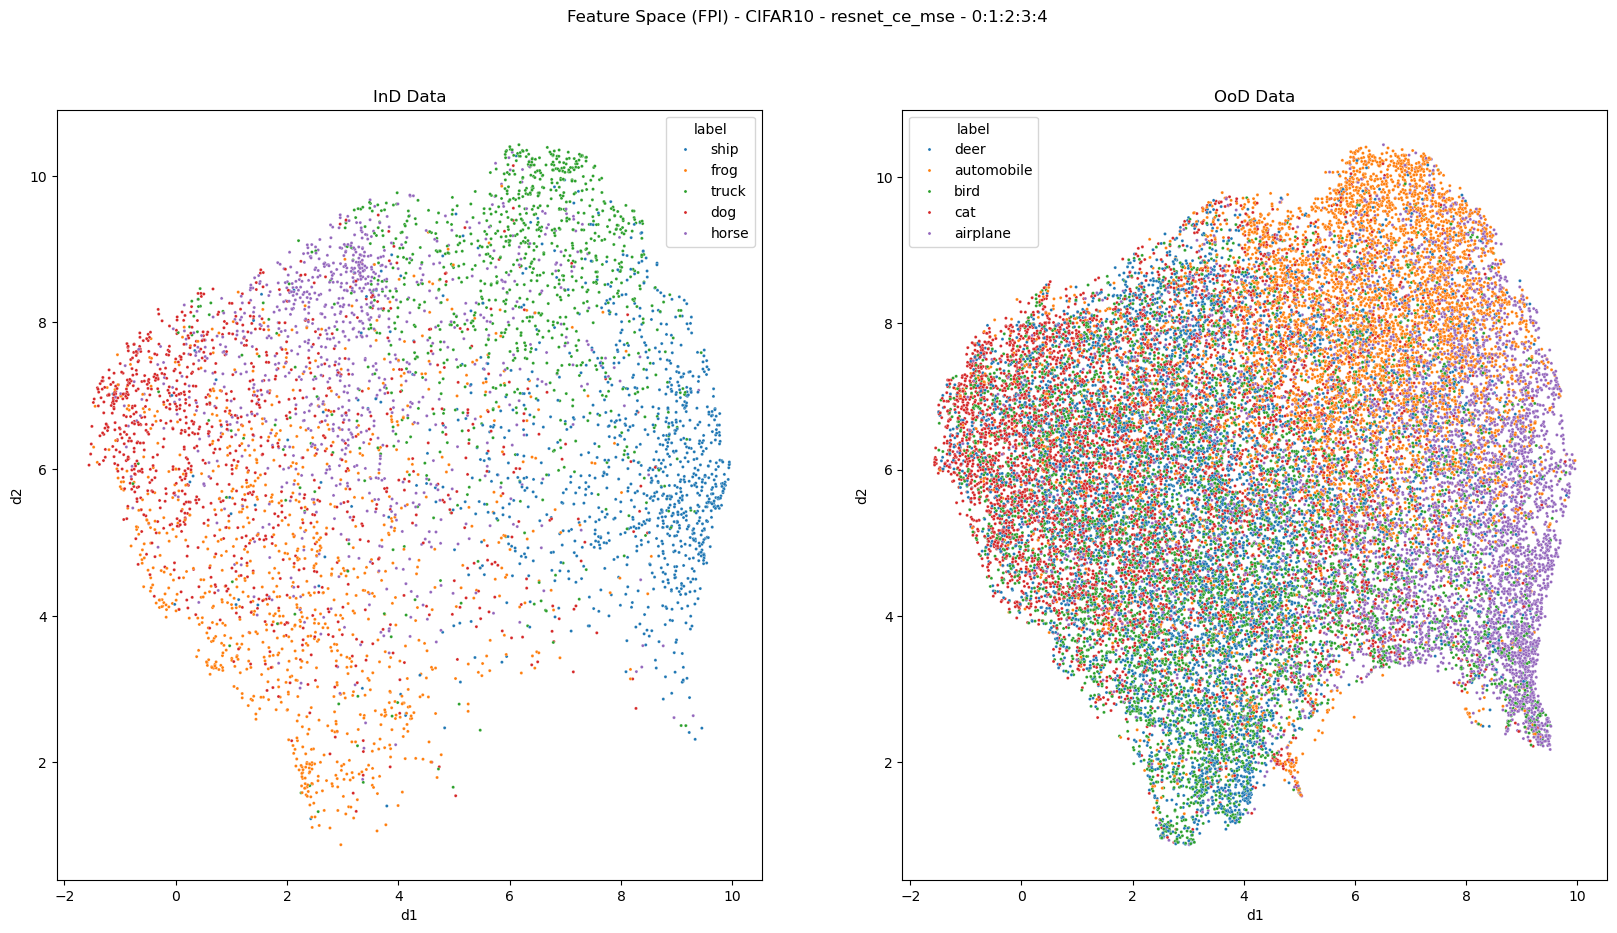

In [13]:
# plot feature space
df_emb_fpi2d = pd.DataFrame()
d1, d2 = ind_emb_fpi2d.T
df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb_fpi2d.T
    df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

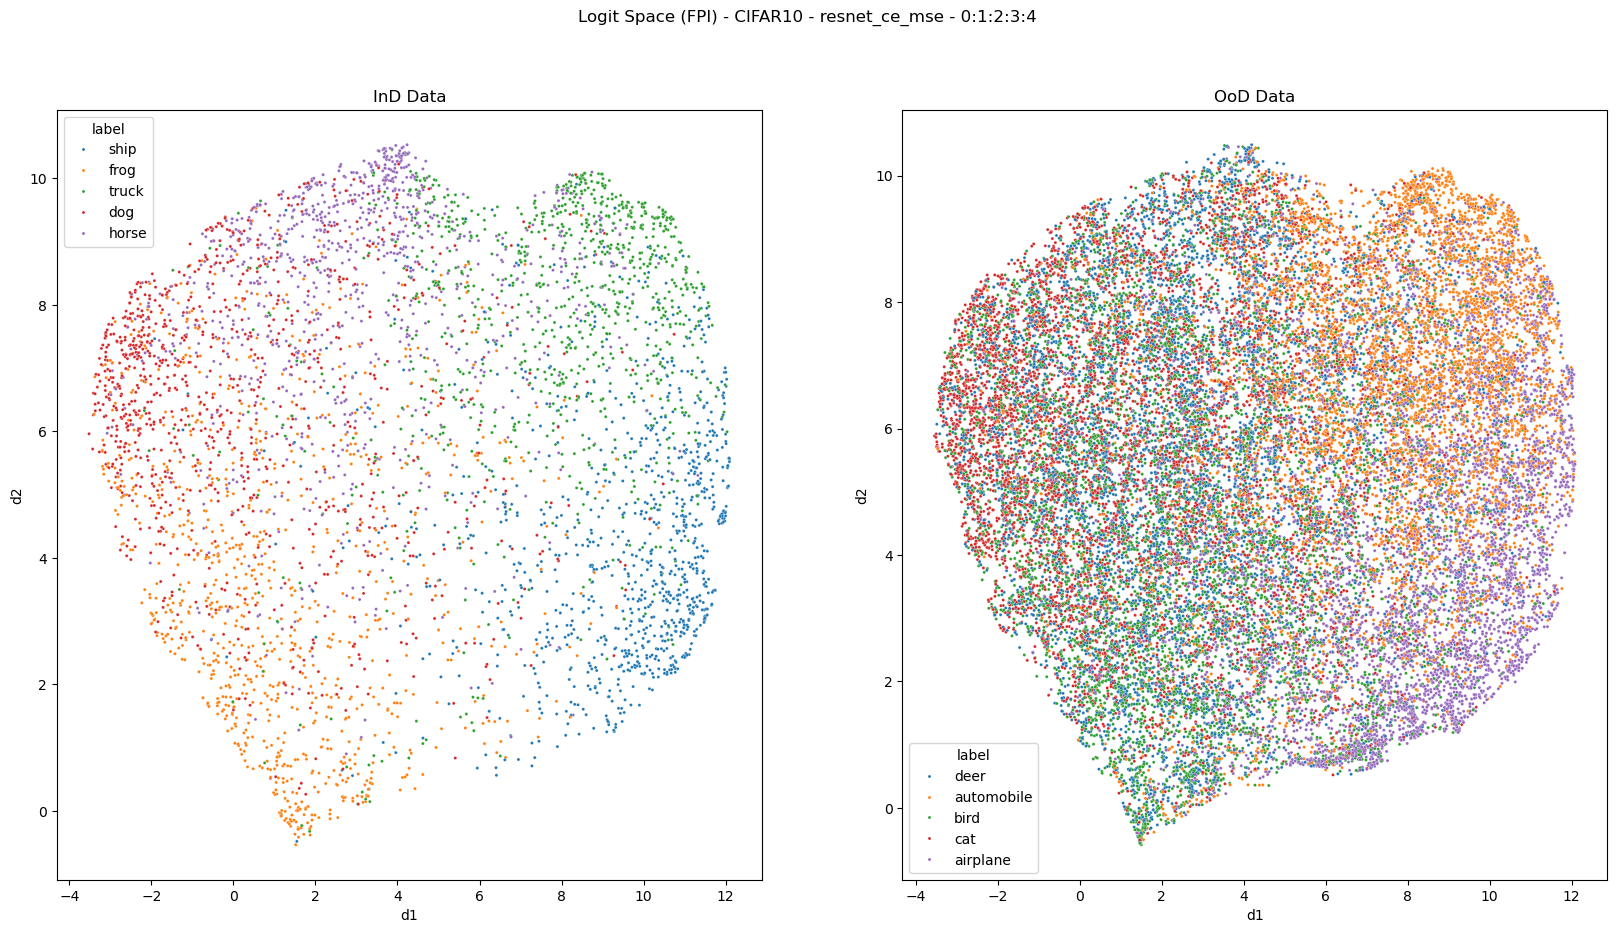

In [14]:
# plot logit space
df_lgt_fpi2d = pd.DataFrame()
d1, d2 = ind_lgt_fpi2d.T
df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt_fpi2d.T
    df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

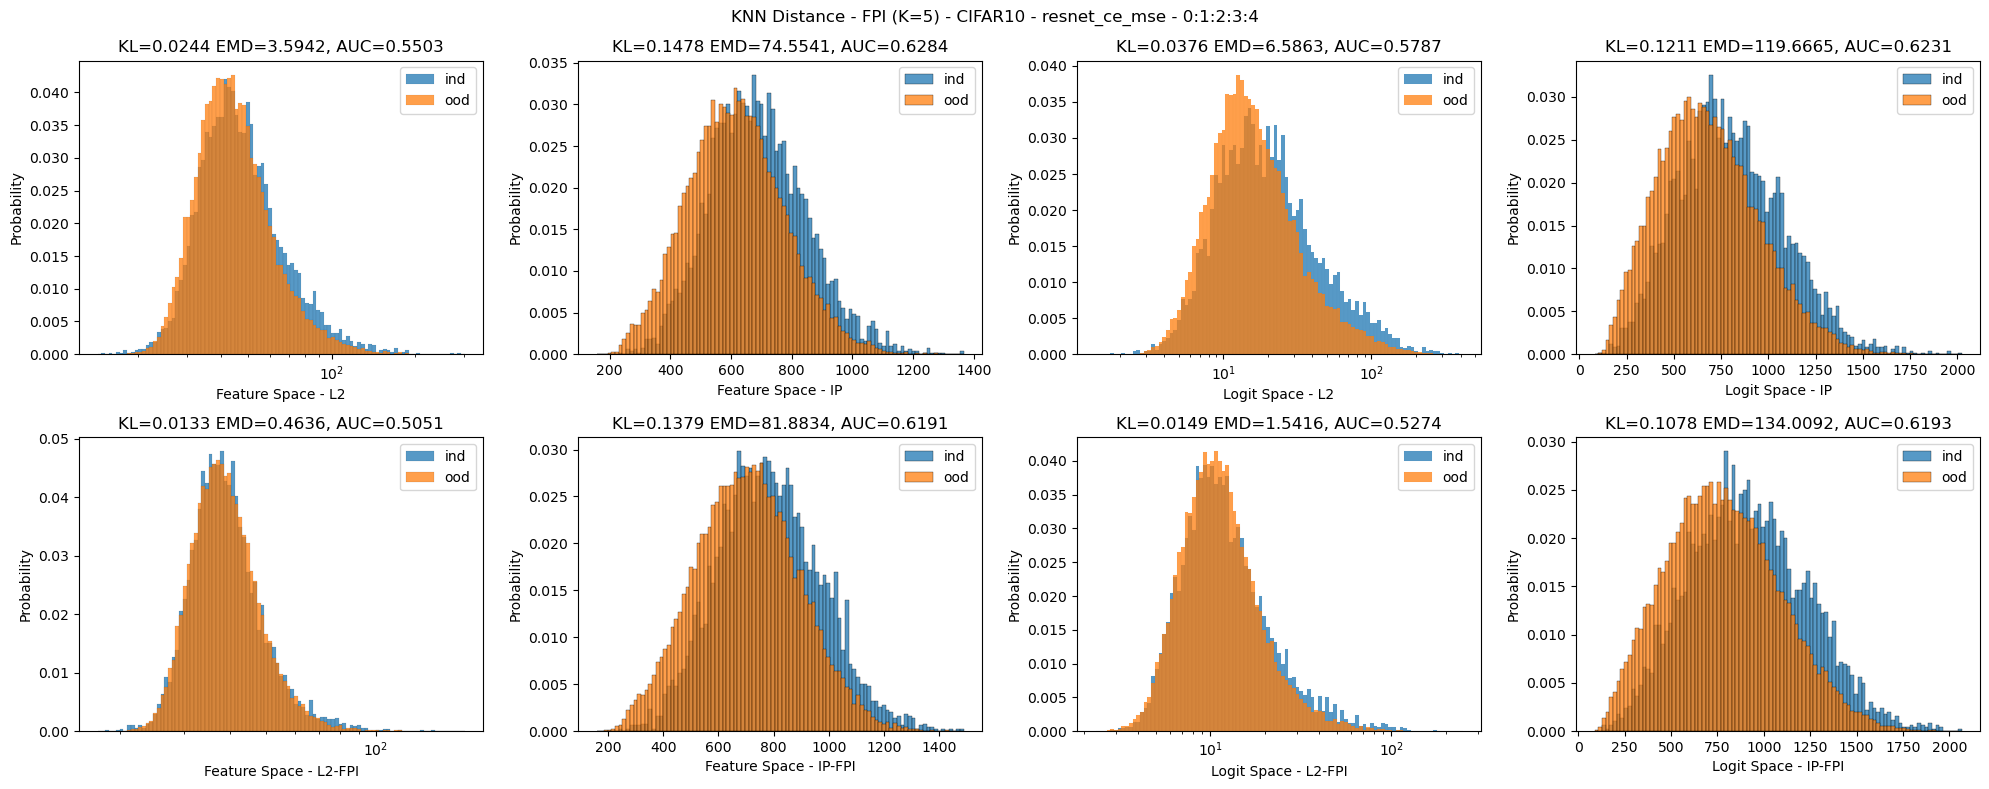

In [15]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
fig.suptitle(f"KNN Distance - FPI (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc))
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0][0], val_emb, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="logspace")
axs[0][0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[0][1], val_emb, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="linspace")
axs[0][1].set_xlabel("Feature Space - IP")
run_stats["knn_l_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0][2], val_lgt, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="logspace")
axs[0][2].set_xlabel("Logit Space - L2")
run_stats["knn_l_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[0][3], val_lgt, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="linspace")
axs[0][3].set_xlabel("Logit Space - IP")
run_stats["knn_f_fp_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[1][0], val_emb_fpi, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="logspace")
axs[1][0].set_xlabel("Feature Space - L2-FPI")
run_stats["knn_f_fp_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1][1], val_emb_fpi, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="linspace")
axs[1][1].set_xlabel("Feature Space - IP-FPI")
run_stats["knn_l_fp_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[1][2], val_lgt_fpi, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="logspace")
axs[1][2].set_xlabel("Logit Space - L2-FPI")
run_stats["knn_l_fp_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1][3], val_lgt_fpi, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="linspace")
axs[1][3].set_xlabel("Logit Space - IP-FPI")
plt.tight_layout()
plt.show()

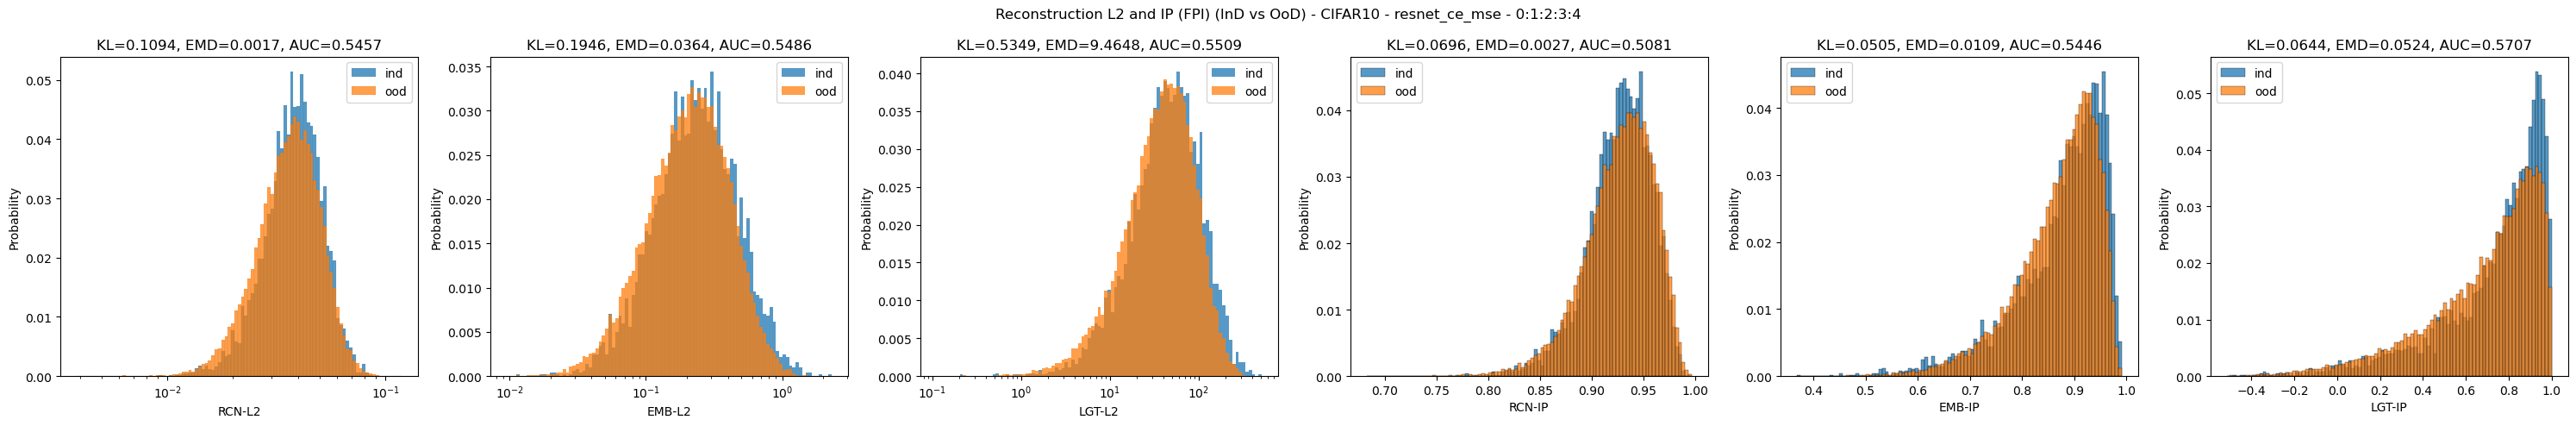

In [16]:
# plot fpi-reconstruction-based ood metrics
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, figsize=(30, 5))

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)

# data
_ind_inp = flatten(ind_inp)
_ind_rcn, _ind_emb, _ind_lgt = flatten(ind_rcn), flatten(ind_emb), flatten(ind_lgt)
_ind_rcn_fpi, _ind_emb_fpi, _ind_lgt_fpi = flatten(ind_rcn_fpi), flatten(ind_emb_fpi), flatten(ind_lgt_fpi)
# unit vectors
_ind_inp_unit = unit(_ind_inp)
_ind_rcn_unit, _ind_emb_unit, _ind_lgt_unit = unit(_ind_rcn), unit(_ind_emb), unit(_ind_lgt)
_ind_rcn_fpi_unit, _ind_emb_fpi_unit, _ind_lgt_fpi_unit = unit(_ind_rcn_fpi), unit(_ind_emb_fpi), unit(_ind_lgt_fpi)
# mse
ind_rcn_l2_fpi = ((_ind_inp - _ind_rcn_fpi) ** 2).mean(-1)
ind_emb_l2_fpi = ((_ind_emb - _ind_emb_fpi) ** 2).mean(-1)
ind_lgt_l2_fpi = ((_ind_lgt - _ind_lgt_fpi) ** 2).mean(-1)
# ip
ind_rcn_ip_fpi = (_ind_inp_unit * _ind_rcn_fpi_unit).sum(-1)
ind_emb_ip_fpi = (_ind_emb_unit * _ind_emb_fpi_unit).sum(-1)
ind_lgt_ip_fpi = (_ind_lgt_unit * _ind_lgt_fpi_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = flatten(ood_inp)
    _ood_rcn, _ood_emb, _ood_lgt = flatten(ood_rcn), flatten(ood_emb), flatten(ood_lgt)
    _ood_rcn_fpi, _ood_emb_fpi, _ood_lgt_fpi = flatten(ood_rcn_fpi), flatten(ood_emb_fpi), flatten(ood_lgt_fpi)
    # unit vectors
    _ood_inp_unit = unit(_ood_inp)
    _ood_rcn_unit, _ood_emb_unit, _ood_lgt_unit = unit(_ood_rcn), unit(_ood_emb), unit(_ood_lgt)
    _ood_rcn_fpi_unit, _ood_emb_fpi_unit, _ood_lgt_fpi_unit = unit(_ood_rcn_fpi), unit(_ood_emb_fpi), unit(_ood_lgt_fpi)
    # mse
    ood_rcn_l2_fpi = ((_ood_inp - _ood_rcn_fpi) ** 2).mean(-1)
    ood_emb_l2_fpi = ((_ood_emb - _ood_emb_fpi) ** 2).mean(-1)
    ood_lgt_l2_fpi = ((_ood_lgt - _ood_lgt_fpi) ** 2).mean(-1)
    # ip
    ood_rcn_ip_fpi = (_ood_inp_unit * _ood_rcn_fpi_unit).sum(-1)
    ood_emb_ip_fpi = (_ood_emb_unit * _ood_emb_fpi_unit).sum(-1)
    ood_lgt_ip_fpi = (_ood_lgt_unit * _ood_lgt_fpi_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

run_stats["rcn_l2"] = plot_rcn(ind_rcn_l2_fpi, ood_rcn_l2_fpi if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("RCN-L2")
run_stats["emb_l2"] = plot_rcn(ind_emb_l2_fpi, ood_emb_l2_fpi if ood_str else None, ax2, scale="logspace")
ax2.set_xlabel("EMB-L2")
run_stats["lgt_l2"] = plot_rcn(ind_lgt_l2_fpi, ood_lgt_l2_fpi if ood_str else None, ax3, scale="logspace")
ax3.set_xlabel("LGT-L2")
run_stats["rcn_ip"] = plot_rcn(ind_rcn_ip_fpi, ood_rcn_ip_fpi if ood_str else None, ax4, scale="linspace")
ax4.set_xlabel("RCN-IP")
run_stats["emb_ip"] = plot_rcn(ind_emb_ip_fpi, ood_emb_ip_fpi if ood_str else None, ax5, scale="linspace")
ax5.set_xlabel("EMB-IP")
run_stats["lgt_ip"] = plot_rcn(ind_lgt_ip_fpi, ood_lgt_ip_fpi if ood_str else None, ax6, scale="linspace")
ax6.set_xlabel("LGT-IP")
plt.suptitle(f"Reconstruction L2 and IP (FPI) (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

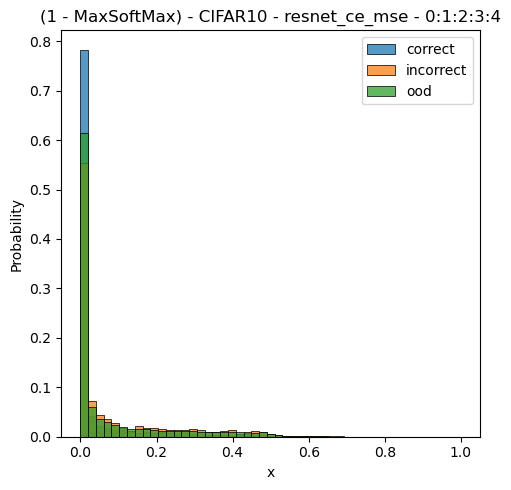

In [17]:
# plot (1 - maxsoftmax) distribution
ind_prob_fpi = np.exp(ind_lgt_fpi.astype(np.float64)) / np.exp(ind_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
ind_pred_fpi = ind_prob_fpi.argmax(-1)
ind_ucty_fpi = -ind_prob_fpi.max(-1) + 1.0

if ood_str:
    ood_prob_fpi = np.exp(ood_lgt_fpi.astype(np.float64)) / np.exp(ood_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred_fpi = ood_prob_fpi.argmax(-1)
    ood_ucty_fpi = -ood_prob_fpi.max(-1) + 1.0

df_t_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df_fpi = pd.concat([df_t_fpi, df_f_fpi], ignore_index=True)
if ood_str:
    df_o_fpi = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df_fpi = pd.concat([df_fpi, df_o_fpi], ignore_index=True)
df_fpi_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t_fpi, x="x", label="correct", stat="probability", bins=df_fpi_bins, ax=ax)
sns.histplot(df_f_fpi, x="x", label="incorrect", stat="probability", bins=df_fpi_bins, ax=ax)
if ood_str:
    sns.histplot(df_o_fpi, x="x", label="ood", stat="probability", bins=df_fpi_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [18]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))

import json
from datetime import datetime
with open(f"assets/results/{datetime.now()}.json", "w") as f:
    json.dump(run_stats, f)